In [34]:
import numpy as np 
import pandas as pd
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
import torch
from featurelearning.models.signet import SigNet
from preprocessing.normalize import crop_center
import tqdm
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cuda


In [3]:
npz_dir = 'C:\\Users\\Mert\\Documents\\GitHub\\sigver\\gpds4k.npz'

In [4]:
with np.load(npz_dir, allow_pickle=True) as data:
        x, y, yforg, user_mapping, filenames = data['x'], data['y'], data['yforg'], data['user_mapping'], data['filenames']

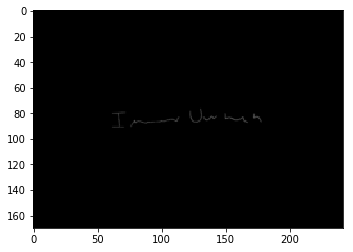

In [5]:
# Plot a sample
plt.imshow(x[2,0,:,:],cmap='gray',vmin=0,vmax=255)
plt.show()

In [6]:
state_dict, classification_layer, forg_layer = torch.load('saved_models/bmgnet.pth')
base_model = SigNet().to(device).eval()
base_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

* Crop the middle 150x220

In [7]:
xc = np.zeros((x.shape[0],1,150,220), dtype=np.uint8)
for idx in tqdm.tqdm(np.arange(x.shape[0]),ascii=True):
    xc[idx,0,:,:] = crop_center(x[idx,0,:,:], (150,220))

100%|#######################################################################| 216000/216000 [00:04<00:00, 51370.42it/s]


In [8]:
del x 

In [9]:
visual_f=np.zeros((xc.shape[0],2048))

In [10]:
visual_f.shape

(216000, 2048)

In [11]:
with torch.no_grad():
    for idx,gpu_slice in enumerate(np.split(xc,200)):
        visual_f[idx*len(gpu_slice):(idx+1)*len(gpu_slice),:] = base_model(torch.tensor(gpu_slice).float().div(255).to(device)).cpu()

In [12]:
visual_f = pd.DataFrame(visual_f)

In [13]:
visual_f.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.118669,1.172929,1.222685,2.436231,0.978623,0.574977,0.439081,0.980337,0.0,...,0.287278,0.0,0.000000,1.463579,0.000000,0.587347,0.006602,0.0,0.166292,0.000000
1,0.0,0.102159,0.000000,0.918733,1.719270,0.456188,0.656368,0.122353,0.956184,0.0,...,0.115727,0.0,0.599104,1.386794,0.027456,0.641405,0.092848,0.0,0.471928,0.055559
2,0.0,0.064985,0.023189,0.782723,0.671646,0.009855,1.407754,0.461963,0.956464,0.0,...,0.411057,0.0,0.716536,1.058748,0.179106,0.684001,0.000000,0.0,0.297305,0.271356
3,0.0,0.059957,0.975151,0.895196,1.933434,0.763008,0.375753,0.155117,1.014449,0.0,...,0.339333,0.0,0.000000,1.109943,0.000000,0.000000,0.000000,0.0,0.449242,0.598309
4,0.0,0.091473,1.442126,1.497808,2.659508,0.081309,0.000000,0.188513,0.729919,0.0,...,0.000000,0.0,0.060842,0.820847,0.068798,0.000000,0.000000,0.0,0.152659,0.000000


In [27]:
sig_ids = np.array([int(fname.split('-')[-1].split('.')[0]) for fname in np.squeeze(filenames)])
user_ids = np.array([int(fname.split('-')[1]) for fname in np.squeeze(filenames)])

In [28]:
filenames_ex = np.expand_dims(filenames,axis=1)
yforg_ex = np.expand_dims(yforg,axis=1)
sig_ids_ex = np.expand_dims(sig_ids,axis=1)
user_ids_ex = np.expand_dims(user_ids,axis=1)

In [29]:
data_f=pd.DataFrame(np.concatenate((filenames_ex, user_ids_ex, sig_ids_ex, yforg_ex),axis=1), columns=['path', 'user_id', 'sig_id', 'fakeness'])

In [36]:
save_path = 'C:\\Users\\Mert\\Documents\\GitHub\\sigver_bmg\\data\\GPDSSyntheticSignatures4k\\bmgnet_features'
data_f.to_csv(os.path.join(save_path,'data_features.csv'),index=False)
visual_f.to_csv(os.path.join(save_path,'visual_features.csv'),index=False)